# Hausaufgabe 3
## Particle Image Velocimetry
<!-- Lizensiert unter (CC BY 4.0) 2021, Gert Herold -->

Zur Charakterisierung der Bewegung in einem Strömungsfeldes findet häufig das optische Messverfahren [Particle Image Velocimetry (PIV)](https://de.wikipedia.org/wiki/Particle_Image_Velocimetry) Anwendung.
Hierfür werden in das Fluid eingebrachte Partikel mit einem zur Ebene aufgeweiteten Laserstrahl beleuchtet und in kurzen Abständen [nacheinander fotografiert](https://www.youtube.com/watch?v=JbuuhpQCWz8).
Aus der Ortsveränderung der Partikel und dem bekannten Abstand zwischen den Aufnahmen können die Geschwindigkeitsvektoren bestimmt werden.

Es sollen Funktionen geschrieben werden, mit deren Hilfe sich Berechnung und Visualisierung eines Geschwindigkeits-Vektorfeldes basierend auf zwei aufgenommenen Bildern realisieren lassen.

Zunächst werden einige Module importiert, die hilfreiche Funktionen zur Verfügung stellen:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

### 1) Einlesen der Daten

**1.1) Schreiben Sie eine Funktion *loaddata()* die zwei Arrays mit (Bildhöhe) $\times$ (Bildbreite) Einträgen zurückgibt, die die Bildinformationen (Helligkeitswerte als Zahl) enthalten.**

  * Als Parameter sollen hierfür zwei Dateipfade übergeben werden. Das Einlesen kann z.B. mittels [imread](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imread.html) geschehen.
  * Eventuell im Bild enthaltene Farbinformationen sind hier nicht weiter von Interesse. Sind im Bild mehrere Farbkanäle pro Pixel enthalten (z.B. RGB), soll die Information auf einen Kanal reduziert werden, z.B. durch Auswahl oder Aufsummierung der Kanäle.
  * Es soll direkt überprüft werden, ob beide Bilder dieselben Abmaße haben. Andernfalls ist eine Fehlermeldung auszugeben: 
  ```python 
        raise ValueError('Dimensions of input images do not match!')
  ```

In [3]:
def loaddata(datenpfad1, datenpfad2):
    X = plt.imread(datenpfad1)
    Y = plt.imread(datenpfad2)
    if X.shape != Y.shape:
        raise ValueError('Dimensions of input images do not match!')
    elif X.ndim > 2:
        X = X[:,:,0]*0.2989+X[:,:,1]*0.5870+X[:,:,2]*0.1140
        Y = Y[:,:,0]*0.2989+Y[:,:,1]*0.5870+Y[:,:,2]*0.1140
    return X, Y

**1.2) Testen Sie das Laden der Dateien. Die verwendeten Dateien finden Sie im separaten Archiv "*img_HA3.zip*".**

  * **Geben Sie die Dimensionen der zurückgegebenen Arrays an, wenn Sie als Input die folgenden Dateipaare verwenden:**

|Bild 1| Bild 2|
|-|-|
|[B005_1.tif](http://www.pivchallenge.org/pub/index.html#b)|[B005_2.tif](http://www.pivchallenge.org/pub/index.html#b)|
|[B038a.bmp](http://www.pivchallenge.org/pub03/index.html#b)|[B038b.bmp](http://www.pivchallenge.org/pub03/index.html#b)|
|[B_010.TIF](http://www.pivchallenge.org/pub05/index.html#b)|[B_014.TIF](http://www.pivchallenge.org/pub05/index.html#b)|
|[A001_1.tif](http://www.pivchallenge.org/pub/index.html#a)|[A001_2.tif](http://www.pivchallenge.org/pub/index.html#a)|
|[A045a.tif](http://www.pivchallenge.org/pub03/index.html#a)|[A045b.tif](http://www.pivchallenge.org/pub03/index.html#a)|

  * **Überprüfen Sie das Verhalten Ihrer Funktion, wenn folgendes Dateipaar geladen wird:**
  
|Bild 1| Bild 2|
|-|-|
|[B038a.bmp](http://www.pivchallenge.org/pub03/index.html#b)|[A001_1.tif](http://www.pivchallenge.org/pub05/index.html#c)|

Die Bilddateien sind Testfälle der "PIV Challenge"-Benchmark-Initiative (http://www.pivchallenge.org/). Die Quellen der jeweiligen Bilder sind in der Tabelle verlinkt.

In [9]:
sammlung=['img/B005_1.tif', 'img/B005_2.tif', 'img/B038a.bmp', 'img/B038b.bmp', 'img/B_010.TIF', 'img/B_014.TIF', 'img/A001_1.tif',
          'img/A001_2.tif', 'img/A045a.tif', 'img/A045b.tif']#,'B038a.bmp','A001_1.tif']

for i in range(0,len(sammlung),2):
    print(loaddata(sammlung[i],sammlung[i+1])[0].ndim)
# print(loaddata('img/B038a.bmp', 'img/A001_1.tif'))

2
2
2
2
2


**1.3) Laden Sie die Daten aus dem Dateipaar (`B005_1.tif`, `B005_2.tif`) und visualisieren Sie den jeweiligen Array-Inhalt in zwei benachbarten Plots.**

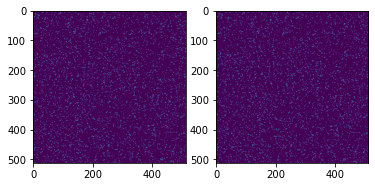

In [10]:
a,b = loaddata(('img/B005_1.tif'),('img/B005_2.tif'))

fig, ax = plt.subplots(1,2)
ax[0].imshow(a)
ax[1].imshow(b)

### 2) Berechnen eines Translationsvektors

__2.1) Schreiben Sie eine Funktion *velocity_vector()*, die zwei 2D-Arrays übergeben bekommt, einen 2D-Verschiebungsvektor zwischen beiden berechnet und diesen zurückgibt.__

  * erstes Array: Suchfenster, zweites Array: Interrogationsfenster
  * "Wie weit muss ich das Interrogationsfenster verschieben, damit es genau das Suchfenster überlagert?"
  * Es genügt, wenn Sie quadratische Arrays betrachten.
  * Falls die Arrays unterschiedlich groß sind, soll die Verschiebung relativ zur Zentrierung beider Arrays miteinander berechnet werden.

Hinweise:

  * Eine zweidimensionale Kreuzkorrelation lässt sich z.B. mit den Funktionen [*correlate2d()*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html) oder [*fftconvolve()*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.fftconvolve.html) aus dem Paket *scipy.signal* berechnen.

In [11]:
# Hier eigenen Code schreiben ...
def velocity_vector(search,interrogation):
    corr = signal.correlate2d(search, interrogation)
    maxpos = np.where(corr == corr.max())
    
    if len(maxpos[0]) > 1: #Randbedingung
        return np.array([[0],[0]]).T 

    versatz = (search.shape[0]+interrogation.shape[0])//2-1
    translation_vector = np.array([maxpos[1]-versatz,maxpos[0]-versatz])
   
    return translation_vector.T
    

**2.2) Testen Sie die Funktion, indem Sie die Translation der Teilchen von Bild `B005_1c_i.tif` zu `B005_1c_s.tif` berechnen und ausgeben.**

In [13]:
a,b = loaddata(('img/B005_1c_s.jpg'),('img/B005_1c_i.jpg'))

velocity_vector(a,b)

array([[20, 10]], dtype=int64)

### 3) Berechnen und Visualisieren eines Geschwindigkeitsfeldes

**3.1) Schreiben Sie eine Funktion _piv()_, die zwei Dateipfade übergeben bekommt und basierend auf den Bilddaten ein Geschwindigkeitsvektorfeld berechnet.**

  * **Zusätzlich zu den beiden Dateipfaden sollen optional mindestens folgende Parameter an die Funktion übergeben werden können:**
    * *size_interr_window*: Seitenlänge (in Pixel) des quadratischen Ausschnitts, dessen Bewegung untersucht werden soll. Standardwert: $20$
    * *size_search_window*: Seitenlänge (in Pixel) des quadratischen Ausschnitts, innerhalb dessen die höchste Korrelation gesucht werden soll. Der Wert muss sinnvollerweise mindestens so groß wie *size_interr_window* sein (andernfalls Fehlermeldung ausgeben). Standardwert: *None* (setzen auf *size_interr_window*, falls nicht angegeben)
  * **Folgende Werte sollen _zurückgegeben_ werden:**
    * *X*, *Y*: jeweils 2D-Arrays, die das Pixel-Koordinatengitter zum Vektorfeld definieren.
    * *U*, *V*: jeweils 2D-Arrays (Dimensionen entsprechen (*len(x), len(y)*), die die Geschwindigkeitskomponenten in x- und y-Richtung enthalten.

Hinweise:

  * Sinnvollerweise sollten zum Laden der Dateien und zum Berechnen einzelner Geschwindigkeitsvektoren bereits von Ihnen geschriebene Funktionen verwendet werden.
  * Die Größe des zurückgegebenen Vektorfeldes bestimmt sich aus der Größe der Ausgangsbilder, der Größe der Interrogationsfenster sowie der Suchfenster. 
    * Für jedes Interrogationsfenster wird genau ein Vektor berechnet.
    * Die quadratischen *Interrogations*fenster grenzen immer direkt aneinander. 
    * Ein zu einem Interrogationsfenster gehörendes *Such*fenster hat den gleichen Mittelpunkt wie das Interrogationsfenster.
    * Je nach Größe der Interrogationsfenster kann es vorkommen, dass verbleibende Werte am "Bildrand" nicht ein volles Interrogationsfenster füllen können.
  * Ein mit Nullen gefülltes Array lässt sich z.B. mit NumPys [*zeros()*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html)-Funktion erzeugen.
  * Für eine leichtere Fehlersuche ist es sinnvoll, mit Testausgaben (oder -plots) zu überprüfen, ob Zwischenschritte den Erwartungen entsprechen.
  * Um aus einem Vektor mit x-Koordinaten und einem Vektor mit y-Koordinaten ein 2D-Gitter aufzuspannen (auf dem alle x- und y-Koordinaten kombiniert werden), kann die NumPy-Funktion [*meshgrid()*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) verwendet werden.

    

In [14]:
def piv(interpfad, searchpfad, size_interr_window = 20, size_search_window=None):
    if size_search_window == None:
        size_search_window = size_interr_window
    elif size_interr_window > size_search_window:
        raise ValueError('Größen der Suchfenster passen nicht zueinander!')
        
    b1,b2 = loaddata((searchpfad),(interpfad))
    X = []
    Y = []
    U = []
    V = []
    
    plt.imshow(b1)
    
    for i in range(0,b2.shape[0],size_interr_window):
        U.append([])
        V.append([])
        X.append([])
        Y.append([])
        
        for j in range(0,b2.shape[1],size_interr_window):
            
            
            X2 = min(i+size_interr_window,b2.shape[0])
            Y2 = min(j+size_interr_window,b2.shape[1])
            
            X[-1].append((i+i+size_interr_window)//2)
            Y[-1].append((j+j+size_interr_window)//2)
            
            k2 = np.zeros((size_interr_window, size_interr_window))
            k2[0:min(i+size_interr_window+1,b2.shape[0])-i,0:min(j+size_interr_window+1,b2.shape[1])-j] = b2[i:X2,j:Y2]
            
            k1 = np.zeros((size_search_window, size_search_window))
            
            k1[max(i,(size_search_window-size_interr_window)//2)-i:min(i+(size_search_window+size_interr_window)//2,b2.shape[0]-(size_search_window+size_interr_window)%2)-i-(-size_search_window+size_interr_window)//2,\
                max(j,(size_search_window-size_interr_window)//2)-j:min(j+(size_search_window+size_interr_window)//2,b2.shape[1]-(size_search_window+size_interr_window)%2)-j-(-size_search_window+size_interr_window)//2] \
                = b1[max(0,i-(size_search_window-size_interr_window)//2):\
                min(b2.shape[0],i+(size_search_window+size_interr_window)//2)+(size_search_window+size_interr_window)%2,\
                      max(0,j-(size_search_window-size_interr_window)//2):\
                min(b2.shape[1],j+(size_search_window+size_interr_window)//2+(size_search_window+size_interr_window)%2)]
            
            a = velocity_vector(k2,k1)
            U[-1].append(a[0][0])
            V[-1].append(a[0][1])
        
    return np.array(X),np.array(Y),np.array(U),np.array(V)
    

**3.2) Erstellen Sie mit Hilfe der _piv()_-Funktion für jeden Datensatz drei Darstellungen:**
  1. Einen Plot mit [Vektorpfeilen](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html), der die Strömungsrichtungen der Partikel(-Gruppen) visualisiert. *Hinweis: Beachten Sie den optionalen Parameter "angles" für eine korrekte Darstellung.*
  2. Eine [Stromlinienvisualisierung](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.streamplot.html).
  3. Einen [Konturplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contourf.html), der den Betrag der Geschwindigkeitsverteilung abbildet.

  * **Wichtig:** Hinterlegen Sie den 3 Sub-Plots zur besseren Übersicht eines der jeweiligen Partikelbilder. 
  * Verändern Sie ggf. die Farbwahl und weitere Darstellungsparameter so, dass die Visualisierung der Strömung gut erkennbar ist.
  * Variieren Sie die Parameter der *piv()*-Funktion sowie der jeweiligen Plot-Funktion, um eine möglichst aussagekräftige Abbildung zu erhalten. 

In [8]:
'''X,Y,U,V = piv(('A001_1.tif'), ('A001_2.tif'),35)
plt.rcParams['figure.figsize'] = (10,10)
plt.quiver(Y,X,U,V, color='black',angles='xy')#,scale=0.5e2)
print(Y.shape)'''


"X,Y,U,V = piv(('A001_1.tif'), ('A001_2.tif'),35)\nplt.rcParams['figure.figsize'] = (10,10)\nplt.quiver(Y,X,U,V, color='black',angles='xy')#,scale=0.5e2)\nprint(Y.shape)"

In [9]:
'''print(U.shape)
plt.streamplot(Y,X,U,V)'''

'print(U.shape)\nplt.streamplot(Y,X,U,V)'

In [10]:
'''plt.contourf(Y,X, (U**2+V**2)**0.5)'''

'plt.contourf(Y,X, (U**2+V**2)**0.5)'

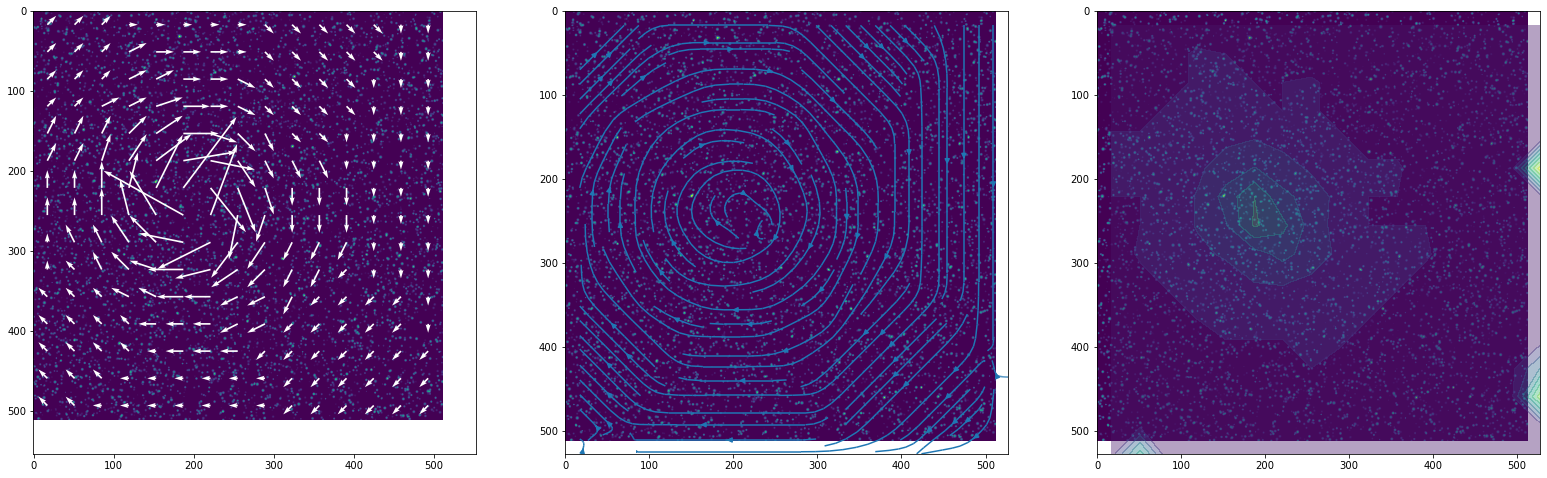

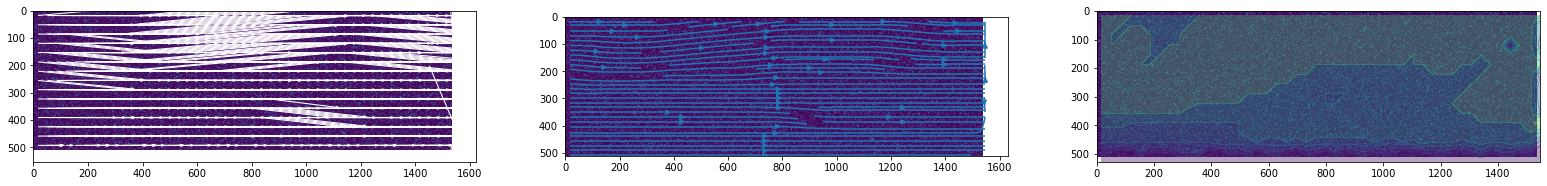

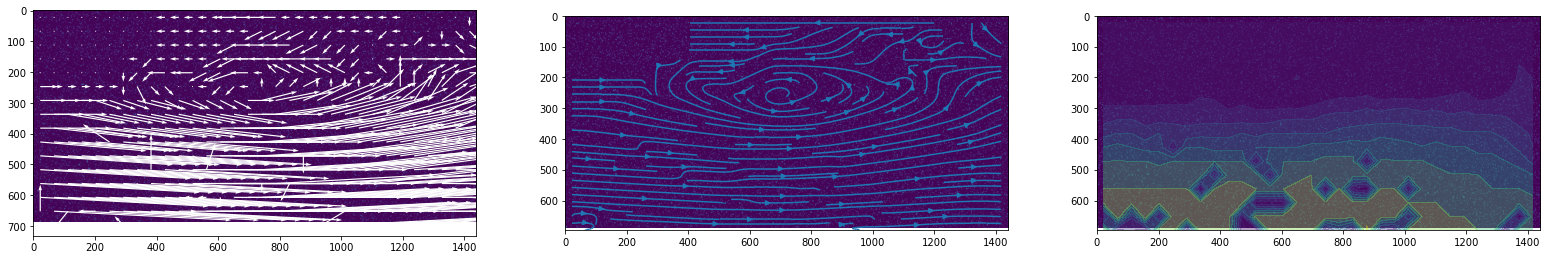

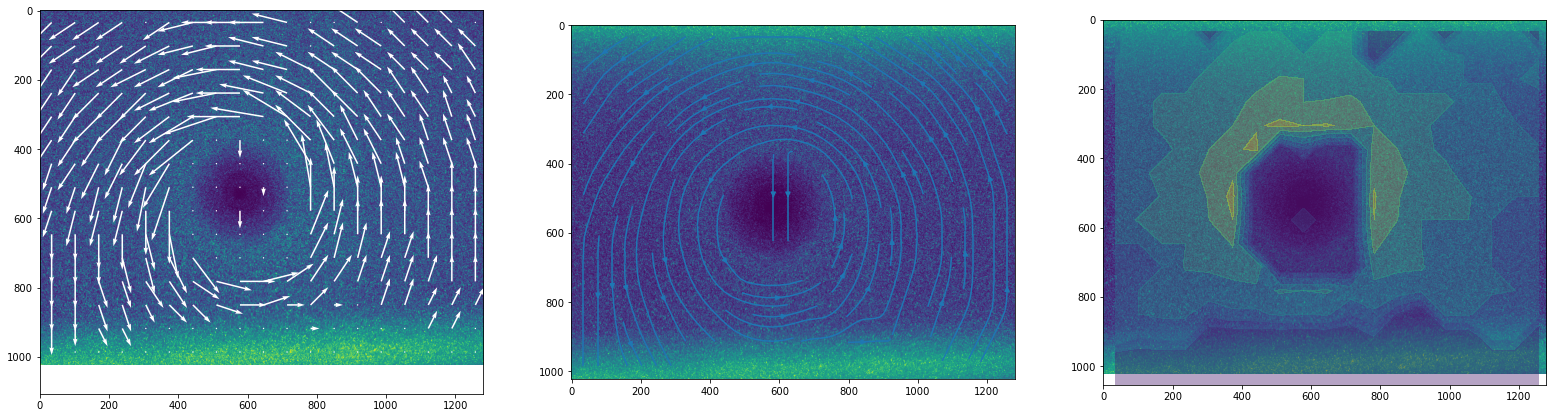

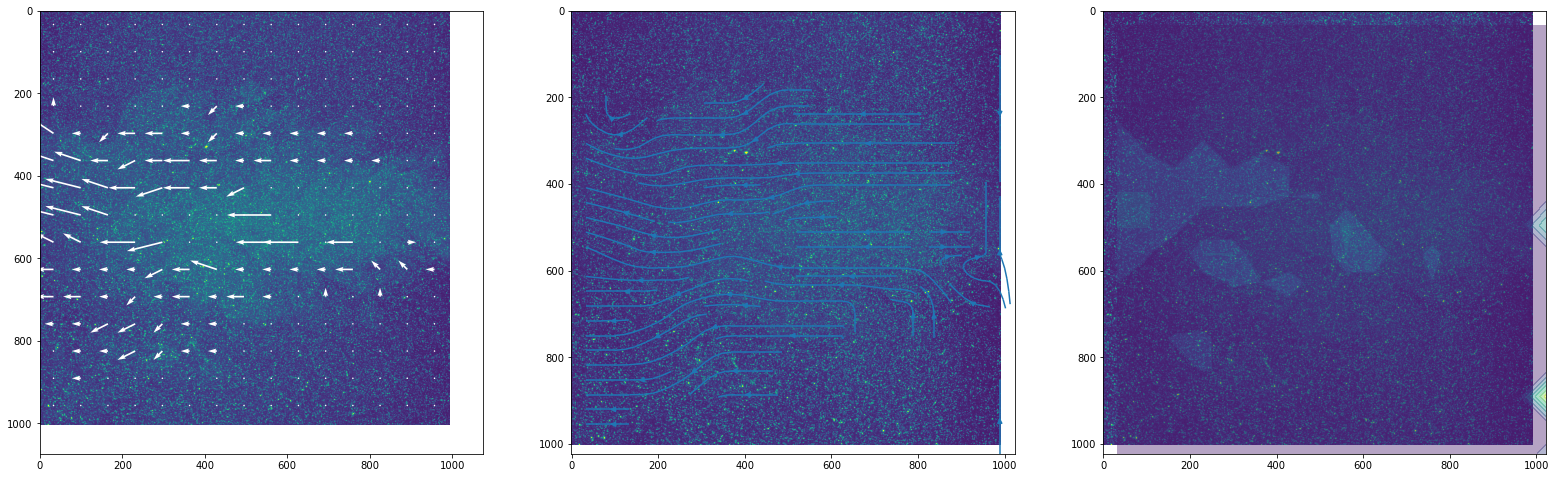

In [15]:
for i in range(0,len(sammlung),2):
    a,b = loaddata(sammlung[i], sammlung[i+1])
    
    plt.figure(i,(27,10))
    
    plt.subplot(1,3,1)
    plt.imshow(a)
    X,Y,U,V = piv( sammlung[i], sammlung[i+1], a.shape[0]//15)
    plt.quiver(Y,X,-U,-V, color='white',angles='xy',scale=0.5e2)
    
    plt.subplot(1,3,2)
    plt.imshow(a)
    plt.streamplot(Y,X,-U,-V)
    
    plt.subplot(1,3,3)
    plt.imshow(a)
    plt.contourf(Y, X, (U**2+V**2)**0.5,alpha = 0.4)




**3.3) Zusatzaufgaben (freiwillig):**
  * Fügen Sie einen optionalen Parameter "overlap" – und die entsprechende Implementierung – für überlappende Interrogationsfenster hinzu.
  * Aktuell können nur Geschwindigkeits-Vektoren mit Pixelgenauigkeit gefunden werden. Überlegen Sie, ob bzw. wie genauere Werte berechnet werden könnten.
  * Wie könnte das Ergebnis verbessert werden, wenn die auftretenden Geschwindigkeiten lokal stark variieren?